In [68]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use("ggplot")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
def get_data():
    used_data = pd.read_csv('../data/data.csv', index_col=0, parse_dates=True)
    return used_data

def get_all_tickers():
    used_data = get_data()
    return used_data.columns

def get_returns():
    used_data = get_data()
    ret_day = used_data.fillna(0)
    S = np.exp(used_data.fillna(0)).cumprod()
    ret_mon = S.resample('M').ffill().pct_change().dropna() # start 2000-02-29
    return ret_day, ret_mon
    
def form_labels(tic):
    ret_day, ret_mon = get_returns()
    median_ret = ret_mon.median(1)
    labels = ret_mon.shift(-1).gt(median_ret.shift(-1), axis=0).astype(int)[tic]
    labels.name = 'label'
    return labels

def form_features(tic):
    ret_day, ret_mon = get_returns()
    
    feature_data = []
        
    daily = ret_day[tic]
    dfs = []
    idx = range(13, len(ret_mon) - 1)
    for t in idx:
        current_y = ret_mon.index[t].year
        current_mon = ret_mon.index[t].month
        next_mon_isjan = (ret_mon.index[t+1].month == 1)
        start = t - 13
        end = t - 2

        ret_mon_slice = ret_mon[tic].iloc[start:end+1]

        last_date = (daily[(daily.index.year == current_y) 
                           & (daily.index.month == current_mon)].last_valid_index())

        last_date_loc = daily.index.get_loc(last_date)
        start_date_loc = last_date_loc - 19

        daily_rets_slice = daily.iloc[start_date_loc:last_date_loc + 1]

        daily_rets_slice.index = ['R_d_' + str(i) for i in range(1, 21)]
        ret_mon_slice.index = ['R_m_' + str(i) for i in range(1, 13)]

        conc = pd.concat([daily_rets_slice, ret_mon_slice])
        conc['JAN'] = next_mon_isjan
        conc['m_ret'] = ret_mon[tic].iloc[t]

        conc = conc.to_frame()
        conc.columns = [t]
        dfs.append(conc)
    feats_t = pd.concat(dfs, axis=1).T
    feature_data.append(feats_t)
    
    date_idx = ret_mon.index[idx]
    feature_data_df = pd.concat(feature_data, axis=0).set_index(date_idx)
    return feature_data_df

def form_feats_labels(tickers):
    full_data_by_tic = []
    for tic in tickers:
        feats = form_features(tic)
        feats["label"] = (feats["m_ret"] > 0).astype(int)
        full_data_by_tic.append(feats)
    return pd.concat(full_data_by_tic, axis=0) # datetime index not unique

In [3]:
train_size = 0.7
tickers = ["FESX", "ES", "NK"]
def split_test_train(train_set_size=train_size, tickers = tickers):
    Xtrains = []
    ytrains = []
    Xtests = []
    ytests = []
    print(tickers)
    for tic in tickers:
        data = form_feats_labels([tic])
        X = data[data.columns[:-2]].as_matrix()
        y = data.label.as_matrix()
        N = len(y)
        train_set_stop = int(N * train_set_size)
        
        Xtrain = X[0:train_set_stop]
        Xtrains.append(Xtrain)
        ytrain = y[0: train_set_stop]
        ytrains.append(ytrain)
        
        Xtest = X[train_set_stop:]
        Xtests.append(Xtest)
        ytest = y[train_set_stop:]
        ytests.append(ytest)
    
    Xtrains_c = np.concatenate(Xtrains)
    ytrains_c = np.concatenate(ytrains)
    Xtests_c = np.concatenate(Xtests)
    ytests_c = np.concatenate(ytests)
    return Xtrains_c, ytrains_c, Xtests_c, ytests_c     

In [4]:
# Data loader abstraction
class CSVDataset(torch.utils.data.Dataset):
    def __init__(self, fname_x, fname_y):
        self.X = np.genfromtxt(fname_x, delimiter=',')
        self.y = np.genfromtxt(fname_y, delimiter=',')

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class LocalDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
# VARIATIONAL AUTOENCODER
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(33, 50)
        self.fc21 = nn.Linear(50, 4)
        self.fc22 = nn.Linear(50, 4)
        self.fc3 = nn.Linear(4, 50)
        self.fc4 = nn.Linear(50, 33)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        # Approximations for mu, log_variance
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = Variable(torch.rand(std.size()), requires_grad=False)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 33))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
        
    def loss_function(self, recon_x, x, mu, logvar):
        MSE = F.mse_loss(recon_x, x.view(-1, 33), size_average=False)
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return MSE + KLD

In [6]:
batch_size = 64
Xtrain, ytrain, Xtest, ytest = split_test_train()
train_dataset = LocalDataset(Xtrain, ytrain)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_dataset = LocalDataset(Xtest, ytest)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

['FESX', 'ES', 'NK']


In [7]:
log_interval = 100
number_of_epochs = 100

vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [8]:
# TRAIN VAE
vae.train()
for epoch in range(number_of_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data.float())
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae.loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
    
    if (epoch+1) % log_interval == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))

====> Epoch: 99 Average loss: 0.1116


In [9]:
vae.eval()
test_loss = 0
for i, (data, _) in enumerate(test_loader):
    data = Variable(data.float(), requires_grad=False)
    recon_batch, mu, logvar = vae(data)
    test_loss += vae.loss_function(recon_batch, data, mu, logvar).data[0]

test_loss /= len(test_loader.dataset)
print('====> Test set loss: {:.4f}'.format(test_loss))

====> Test set loss: 0.4092


In [10]:
# Build encoded dataset
def get_encoded_data(data_loader, model):
    Xenc = np.array([])
    yenc = np.array([])
    for _, (data, target) in enumerate(data_loader):
        data = Variable(data.view(-1,33)).float()
        labels = Variable(target).type(torch.LongTensor)

        _, data, _ = model(data)

        batch = data.cpu().data.numpy()
        if len(Xenc) == 0:
            Xenc = batch
            yenc = target.numpy()
        else:
            Xenc = np.vstack((Xenc, batch))
            yenc = np.append(yenc, target.numpy())
            
    return Xenc, yenc

0.6284772464574683


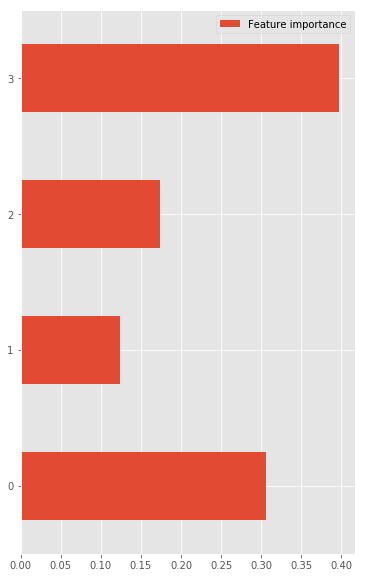

In [79]:
# Get encoded training set
X_train_enc, y_train_enc = get_encoded_data(train_loader, vae)

# Train classifier that uses encoded data
random_forest_clf = RandomForestClassifier(max_depth=3, random_state=0)
random_forest_clf.fit(X_train_enc, y_train_enc)
score = cross_val_score(random_forest_clf, X_train_enc, y_train_enc)
print(score.mean())

# Plot prefered features
# TODO add column names
rf_df = pd.DataFrame(random_forest_clf.feature_importances_)
rf_df.columns = ["Feature importance"]
rf_df.plot(kind='barh', figsize=(6,10))
plt.savefig("feature_importance.eps")

In [12]:
# TEST SET
X_test_enc, y_test_enc = get_encoded_data(test_loader, vae)

predicted_labels = random_forest_clf.predict(X_test_enc)
print("Number of 1s", sum(predicted_labels))
print("Number of observations", y_test_enc.size)
correct_labels = sum(predicted_labels == y_test_enc)
total = predicted_labels.size
print("ACCURACY", correct_labels/total)

Number of 1s 152
Number of observations 183
ACCURACY 0.7049180327868853


In [13]:
def get_positions(prediction_outputs):
    result_df = pd.DataFrame(prediction_outputs, columns=["loser_p", "winner_p"])
    label = (result_df.loc[:,"winner_p"] > result_df.loc[:,"loser_p"]).astype(int) # <
    result_df["longshort"] = label.map({1: 1, 0: -1})

    print("Predicted long count:", sum(label))

    return result_df["longshort"].as_matrix()

In [33]:
def get_vol_adjusted_returns(ticker, position_returns, targe_vol=0.05, ewm_period=60):
    ret_day, ret_mon = get_returns()
    ret_day = ret_day[ticker]
    ret_mon = ret_mon[ticker]
    

    leverage = targe_vol/(ret_day.ewm(ewm_period).std()*np.sqrt(250))
    leverage_mon = leverage.resample('BM').ffill()
    # Drop last row
    leverage_mon = leverage_mon[:-1]
    # Take the last n rows
    leverage_mon = leverage_mon.tail(len(position_returns))
    return position_returns * leverage_mon.as_matrix()

Predicted long count: 54


/u/13/toiviav1/unix/.conda/envs/dippa/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/u/13/toiviav1/unix/.conda/envs/dippa/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/u/13/toiviav1/unix/.conda/envs/dippa/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Predicted long count: 49
Predicted long count: 49
Sharpe 2.2182021725516634


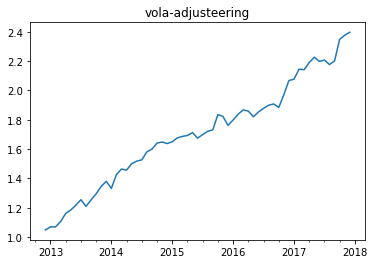

In [40]:
# Optimize this code if time

vol_adj_returns = pd.DataFrame()
ticker = ["ES", "FESX", "NK"]
for ticker in ticker:
    data = form_feats_labels([ticker])
    test_data = data.iloc[141:]

    es_dataset = LocalDataset(test_data[test_data.columns[:-2]].as_matrix(), test_data["label"].as_matrix())
    es_loader = torch.utils.data.DataLoader(es_dataset, batch_size=batch_size)

    X_es_enc, y_es_enc = get_encoded_data(es_loader, vae)
    positions = get_positions(random_forest_clf.predict_proba(X_es_enc))

    test_data["position"] = positions
    test_data["position_return"] = test_data["position"] * test_data["m_ret"]

    test_data["vol_adjusted"] = get_vol_adjusted_returns(ticker, test_data["position_return"], targe_vol=0.15)
    vol_adj_returns[ticker] = test_data["vol_adjusted"]

total_returns = vol_adj_returns.mean(1)

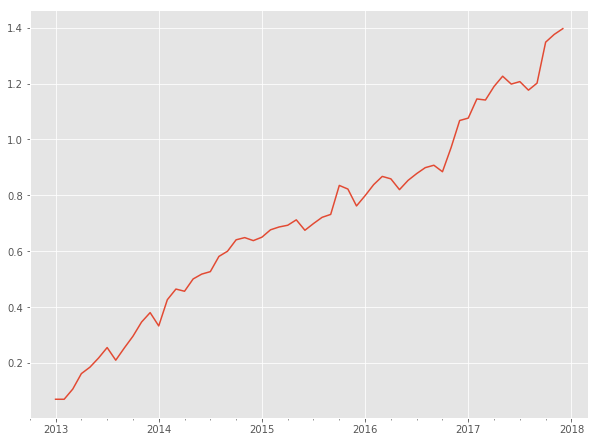

In [77]:
m = total_returns.mean() * 12
s = total_returns.std() * np.sqrt(12)

# MOTHLY AVG PLOT
cum_returns = ((total_returns + 1).cumprod() -1)
cum_returns = cum_returns[1:]
cum_returns.plot(figsize=(10, 7.5))
plt.savefig("cum_port_returns.eps",
            bbox_inches='tight',
            transparent="True",
            pad_inches=0)

In [63]:
torch.save(vae, 'vae_sweetspot.pt')
torch.save(vae.state_dict(), 'vae_sweetspot_no_class.pt')

/u/13/toiviav1/unix/.conda/envs/dippa/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [66]:
# DAILY JUHIS
plt.ylim([0,2])
juhis_df = pd.read_csv('../data/benchmark.csv', parse_dates=False)
juhis_df = juhis_df.tail(1259)

juhis_df["daily_returns"] = (juhis_df["Returns"] + 1).pct_change()
juhis_df["Returns"] = juhis_df["Returns"] / juhis_df["Returns"].iloc[0] - 1

m = juhis_df["daily_returns"].mean() * 250
s = juhis_df["daily_returns"].std() * np.sqrt(250)
juhis_df["Returns"].plot(title=f'Juhis returns, sharpe: {round(m/s, 4)}')

,R_d_1,R_d_2,R_d_3,R_d_4,R_d_5,R_d_6,R_d_7,R_d_8,R_d_9,R_d_10,...,R_m_9,R_m_10,R_m_11,R_m_12,JAN,m_ret,label,position,position_return,vol_adjusted
2012-12-31,0.003696,-0.003175,0.011677,0.002623,0.000523,-0.001569,0.006810,0.007804,0.009809,0.000511,...,-0.046967,0.026258,0.014110,0.013853,1.0,0.119477,1,1,0.119477,0.111125
2013-01-31,-0.001390,-0.012993,-0.017866,0.019148,0.014561,0.012500,0.006401,-0.011358,-0.020680,0.022525,...,0.026258,0.014110,0.013853,0.049251,0.0,0.028852,1,1,0.028852,0.022561
2013-02-28,0.005401,-0.012826,0.011649,0.011957,-0.007002,-0.016307,0.023297,-0.002189,-0.004827,-0.008818,...,0.014110,0.013853,0.049251,0.119477,0.0,0.021072,1,1,0.021072,0.016162
2013-03-31,0.005672,0.006399,0.007630,0.020194,0.002887,0.022615,-0.000804,-0.015694,0.009403,0.008505,...,0.013853,0.049251,0.119477,0.028852,0.0,0.066724,1,1,0.066724,0.054302
2013-04-30,0.001635,0.067727,0.006114,0.026586,-0.009619,0.016436,-0.002573,-0.008843,-0.027509,0.023700,...,0.049251,0.119477,0.028852,0.021072,0.0,0.151407,1,1,0.151407,0.102519


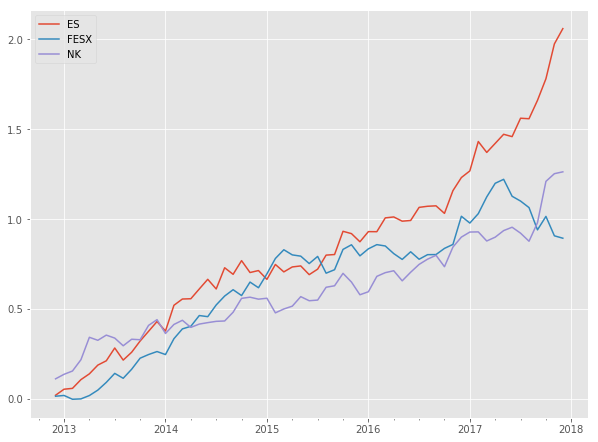

In [83]:
asd = ((vol_adj_returns + 1).cumprod() - 1)
asd.plot(figsize=(10, 7.5))
plt.savefig("vol_adj_ret.eps",
            bbox_inches='tight',
            pad_inches=0)